<a href="https://colab.research.google.com/github/Hriman-Mahanta/Flood_Image_Segmentation/blob/main/IP_Project_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.vision.core import *
from fastai import metrics

In [ ]:
# It mounts Google Drive to access the dataset.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path=Path("/content/drive/MyDrive/Refined_Images/")

In [ ]:
def get_tuple_files(path):
    # Get all image files in the given path
    files = get_image_files(path)
    
    # Filter the files to keep only those ending with 'vhr.tif'
    files = [f for f in files if f.name.endswith('vhr.tif')]
    
    # Return the filtered list of files
    return files

# Call the function to get the tuple files
files = get_tuple_files(path)

(#1876) [Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3307300UTM15R_0_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3307300UTM15R_1_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3307300UTM15R_2_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3307300UTM15R_3_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3307400UTM15R_0_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3307400UTM15R_1_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3307400UTM15R_2_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3307400UTM15R_3_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3306900UTM15R_0_vhr.tif'),Path('/content/drive/MyDrive/Refined_Images/DATA_HAR/E247000N3306900UTM15R_1_vhr.tif')...]

In [ ]:
def label_func(x):
      return str(x.parents[0]/x.stem[0:23])+"_mask_flood.tif";

In [ ]:
seg = DataBlock(
    blocks=(ImageBlock(), MaskBlock(codes=['n', 'y'])),
    item_tfms=[Resize(512, method='squish', resamples=(Image.BICUBIC, Image.BICUBIC)), ToTensor],
    batch_tfms=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)],
    get_items=get_tuple_files,  # Use the get_tuple_files function to get the tuple files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Split the data into train and validation sets
    get_y=label_func  # Use the label_func to get the corresponding flood mask file
)

In [ ]:
seg.summary(path)

Setting-up type transforms pipelines
Found 1876 items
2 datasets of sizes 1501,375
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/Refined_Images/DATA_HAR/E248900N3306100UTM15R_3_vhr.tif
    applying PILBase.create gives
      PILImage mode=RGB size=512x512
  Pipeline: label_func -> PILBase.create
    starting from
      /content/drive/MyDrive/Refined_Images/DATA_HAR/E248900N3306100UTM15R_3_vhr.tif
    applying label_func gives
      /content/drive/MyDrive/Refined_Images/DATA_HAR/E248900N3306100UTM15R_3_mask_flood.tif
    applying PILBase.create gives
      PILMask mode=L size=512x512

Final sample: (PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)


Found 1876 items
2 datasets of sizes 1501,375
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> Resize -- {'siz

In [ ]:
data = seg.dataloaders(path, bs=8)  # Create the dataloaders using the seg configuration and the specified path
learn = unet_learner(data, resnet34, metrics=[Dice()])  # Create a UNet learner using the dataloaders, resnet34 backbone, and Dice metric

learn.summary()  # Print the summary of the learner's model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 67.4MB/s]


DynamicUnet (Input shape: 8 x 3 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 256 x 256  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 128 x 128  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
#Train the data with 5 epochs and learning rate of 2*10^-3
learn.fine_tune(5,base_lr=2e-3)

In [ ]:
learn.save("patch-flood")

In [ ]:
learn.export("patch-flooded_3.pkl")

In [ ]:
!cp patch-flooded.pkl /content/drive/MyDrive/

In [ ]:
learn = load_learner('/content/drive/MyDrive/patch-flooded_3.pkl')

In [ ]:
# Load the VHR image
im = PILImage.create("/content/drive/My Drive/dataset/E246800N3305800UTM15R/vhr.tif")

# Load the flood mask image
im_mask_flood = PILMask.create("/content/drive/My Drive/dataset/E246800N3305800UTM15R/flooded1m.tif")

# Reshape and process the VHR image
z = im.reshape(1024, 1024, resample=3)
z = image2tensor(z)
z = z[:, 0:512, 0:512]
z = z.permute((1, 2, 0))
im = PILImage.create(z.cpu().numpy())

# Reshape and process the flood mask image
zm = im_mask_flood.reshape(1024, 1024, resample=3)
zm = image2tensor(zm)
zm = zm[-1, 0:512, 0:512]
im_mask = PILMask.create(zm.cpu().numpy())


<Axes: >

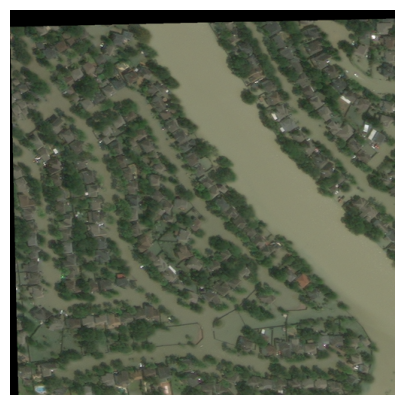

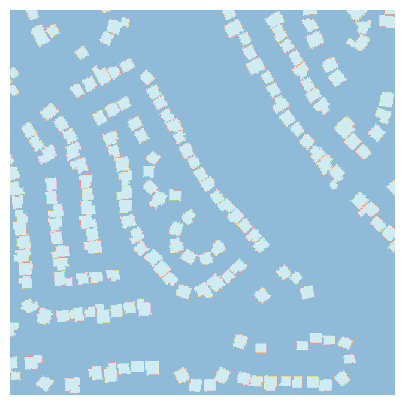

In [ ]:
im.show()
im_mask.show()

<Axes: >

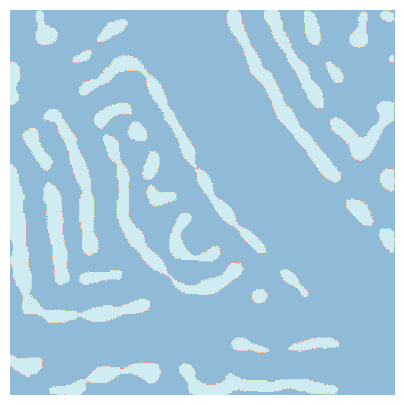

In [ ]:
PILMask.create(learn.predict(im)[0]).show()